# Traffic light detection

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm

%matplotlib inline
plt.style.use('ggplot')

## Object Detection Inference

In this part of the lab you'll detect objects using pretrained object detection models. You can download the pretrained models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [ ]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes, categories):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if classes[i] in categories and scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        # The input placeholder for the image.
        # `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
        image_tensor = graph.get_tensor_by_name('image_tensor:0')

        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = graph.get_tensor_by_name('detection_boxes:0')

        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = graph.get_tensor_by_name('detection_scores:0')

        # The classification of the object (integer id).
        detection_classes = graph.get_tensor_by_name('detection_classes:0')
    return graph, image_tensor, detection_boxes,detection_scores,detection_classes

Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or least the ones we care about for detecting objects.

Run detection and classification on a sample image.

In [16]:
def detect(detection_graph,
           image_tensor, 
           detection_boxes,
           detection_scores,
           detection_classes,
           image_np,
           categories,
           runs=1):
  
    with tf.Session(graph=detection_graph) as sess:                
        # Actual detection.
        (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                            feed_dict={image_tensor: image_np})

        # Remove unnecessary dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes)

        confidence_cutoff = 0.8
        traffic_lights_class_id=10
        # Filter boxes with a confidence score less than `confidence_cutoff`
        boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes,[traffic_lights_class_id])
        return boxes, scores, classes

def ilustrate_detection(boxes, classes,model):
        # The current box coordinates are normalized to a range between 0 and 1.
        # This converts the coordinates actual location on the image.
        width, height = image.size
        box_coords = to_image_coords(boxes, height, width)

        # Each class with be represented by a differently colored box
        draw_boxes(image, box_coords, classes)
        fig = plt.figure(figsize=(12, 8))
        fig.suptitle(model, fontsize=10)
        plt.imshow(image) 

In [17]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
import glob
frozen_model_paths=[graph for graph in glob.iglob('models/**/*.pb', recursive=True)]
test_image_paths= [ graph for graph in glob.iglob('test_images/*.jpg', recursive=True)]

In [18]:
traffic_sign_class_id = 10

Wall time: 3min 58s
Wall time: 1min 45s
Wall time: 1min 8s
Wall time: 28.9 s
Wall time: 17.8 s


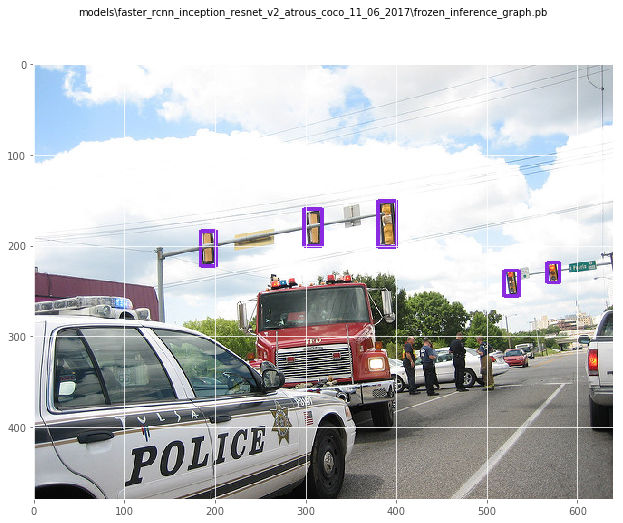

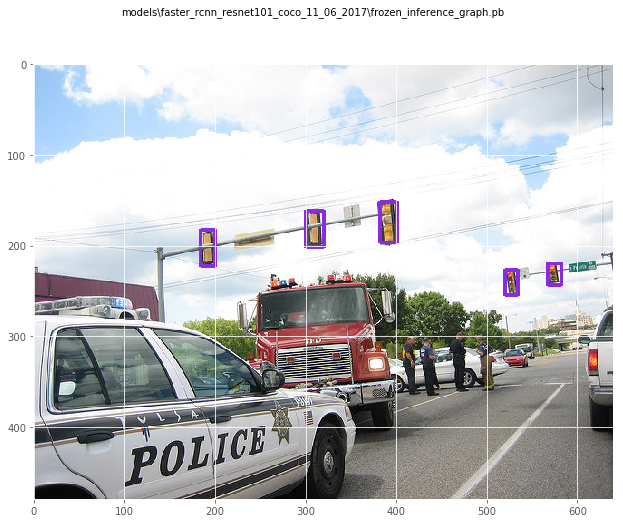

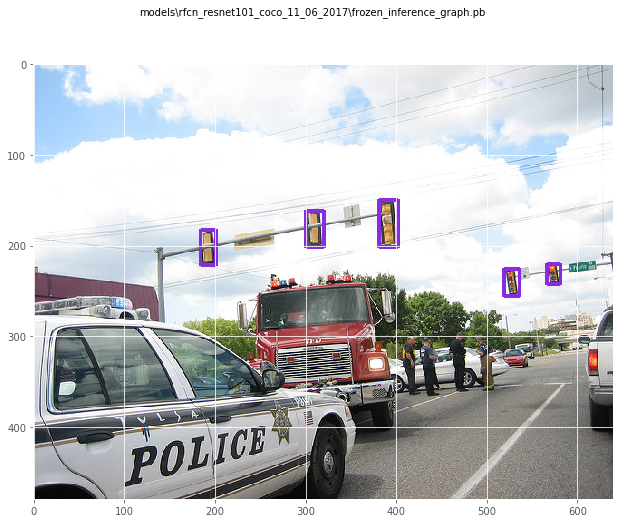

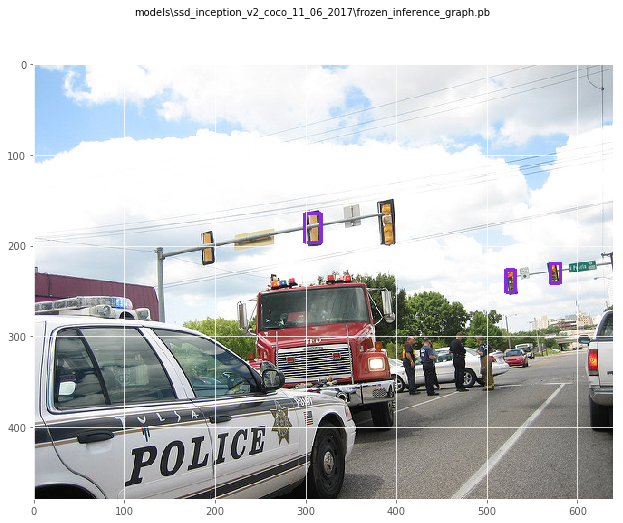

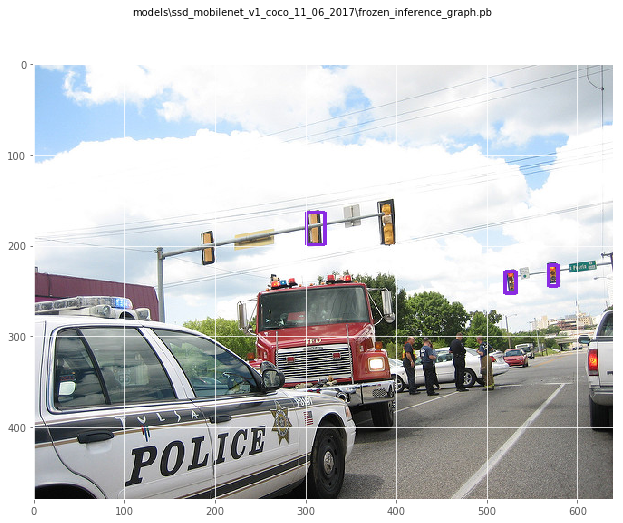

In [26]:
for model in frozen_model_paths:
    detection_graph,image_tensor,detection_boxes,detection_scores,detection_classes = load_graph(model)
    for image_path in test_image_paths:
        image = Image.open(image_path)
        image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
        %time boxes,scores,classes = detect(detection_graph,image_tensor,detection_boxes,detection_scores,detection_classes,image_np,traffic_sign_class_id)
        ilustrate_detection(boxes,classes,model)

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [ ]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [ ]:
with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, 600, 1000, runs=10)

In [ ]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)